<a href="https://colab.research.google.com/github/skylerlewis/nwca-wetland-remote-sensing/blob/main/nwca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

Install packages (these are the packages that are not available on the Google cloud servers)

In [1]:
# install packages in the virtual environment
# if there are errors, force restart the environment (factory reset runtime)
!pip install -q pandas fiona shapely pyproj rtree pygeos #--upgrade --force-reinstall
!pip install -q geopandas #--upgrade --force-reinstall
!pip install -q rasterio rioxarray
!pip install -q -U PyDrive
#!pip install pysal
!pip install cartopy


     |████████████████████████████████| 15.4 MB 32 kB/s 
     |████████████████████████████████| 6.6 MB 25.3 MB/s 
     |████████████████████████████████| 994 kB 26.2 MB/s 
     |████████████████████████████████| 2.0 MB 42.2 MB/s 
     |████████████████████████████████| 994 kB 5.3 MB/s 
     |████████████████████████████████| 19.3 MB 36.2 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 12.1 MB 152 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 219 kB 48.8 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516264 sha256=fd9b936401b575ec495c0f3e367afa7b025e43223e2dd992875ab3c0f2842d68
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/

In [2]:
# setup for accessing files via Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user() # opens auth prompt the first time it's run
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def file_from_gdrive(filename, driveid):
    downloaded = drive.CreateFile({"id": driveid}) 
    downloaded.GetContentFile(filename)
    return filename

# mount files from google drive (after running, they will be accessible by filename without any path prefix)
file_from_gdrive("Site_comparison_2011_2016.csv", "1PoYS_fbE1lYwi3ydbpXKkuP8YqoBFjnf")
file_from_gdrive("README.csv", "1G5l8L2FgM0EebEKbjy06OWdsfGs47i3c")
file_from_gdrive("Aggr_Ecoregions_2015.zip", "1UqUM1mrj6qptAxSY8c1OGc3zRP_p7bVM")
file_from_gdrive("SubDataset_NWCA_2011.csv", "1QFbR0NoFo7go9hXp690yvb1_G-FjJTUV")
file_from_gdrive("RS_stability_NDVI_7_15_21.csv", "1-0dqvcgYokChh0dVZS8f7S7AfHVXr5pE")
# alternately, mount google drive and access via "/content/drive/MyDrive/nwca/filename..."

def unzip_shapefile(filename):
    import io
    from fiona.io import ZipMemoryFile
    zipshp = io.BytesIO(open(filename, "rb").read())
    with (ZipMemoryFile(zipshp)) as memfile:
        with memfile.open() as src:
            crs = src.crs
            gdf = gpd.GeoDataFrame.from_features(src, crs=crs)
    return gdf

# Package imports
see https://www.scipy.org/citing.html
https://geopandas.org/about/citing.html
http://citebay.com/how-to-cite/statsmodels/ 

In [3]:
# basics
import os
import datetime as dt
from functools import reduce
import urllib

# matrix alg and data
import numpy as np
import pandas as pd
from pandas import IndexSlice as idx
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", '{:0.2f}'.format)
import xarray as xr 
import scipy

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# geospatial data
import shapely
import geopandas as gpd 
import rasterio as rio
import rioxarray
global_crs = "EPSG:5070" # NAD83 CONUS ALBERS

# statistics
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_squared_log_error
from sklearn.decomposition import PCA

import cartopy

# spatial statistics
# import pysal
# from libpysal.weights import lat2W, KNN
# from esda.moran import Moran

#EAEDEB
diverging_cmap = "vlag_r"
diverging_cmap = mpl.colors.LinearSegmentedColormap.from_list(name="vlag_custom", colors=["#FFAE34", "#FFFFFF", "#8CC2CA"])


/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Custom functions

In [4]:
# function to keep only intersecting features
def subset_by_sindex(target_features, by_features, predicate="intersects") -> gpd.GeoDataFrame:
    """ Uses one geodataframe/geometry to query another. 
            Predicate is one of ['intersects', 'within', 'contains', 'overlaps', 'crosses', 'touches'] """
    inp, res = by_features.sindex.query_bulk(target_features.geometry, predicate=predicate)
    return target_features[np.isin(np.arange(0, len(target_features)), inp)]

# function to generate matplotlib colormap from list
def gen_cmap(palette: list) -> mpl.colors.LinearSegmentedColormap:
    """ Returns a matplotlib colormap given a list of color strings."""
    colors = [(i / (len(palette) - 1), x) for i, x in enumerate(palette)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", colors, len(palette))
    return cmap

def make_ellipse(x: np.ndarray, y: np.ndarray, n_std=3.0, type="confidence", **kwargs) -> mpl.patches.Ellipse:
    from scipy.stats import norm, chi2
    # calculate ellipse dimensions
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    if type == "confidence":
        # confidence ellipse
        q = 2 * norm.cdf(n_std) - 1
        r2 = chi2.ppf(q, 2)
        width, height = 2 * np.sqrt(vals * r2)
    elif type == "error":
        # error ellipse
        width, height = 2 * n_std * np.sqrt(vals)
    #print(width, height, theta)
    # center of ellipse
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    # create ellipse
    ellipse = mpl.patches.Ellipse(xy=(mean_x, mean_y), width=width, height=height, angle=theta, **kwargs)
    return ellipse

def flatten_columns(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d.columns = ['_'.join(tup).rstrip('_') for tup in d.columns.values]
    return d

def quick_vif(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor 
    v = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return pd.Series(v, index = df.columns)

def quick_skedplot(modelfit, title=None):
    pred_mod = modelfit.predict()
    res_mod = modelfit.resid
    fig, ax = plt.subplots(figsize=(10,6))
    x = pred_mod
    y = res_mod
    if title is None:
        plt.title("Homoskedasticity Test Plot")
    else:
        plt.title(title)
    plt.axhline(y=0, color="black", linestyle=":") 
    ax.scatter(x, y)
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals")  
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x1, loc: "{:,}".format(int(x1))))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y1, loc: "{:,}".format(int(y1))))
    sns.despine(trim=True)
    plt.show()

def quick_skedtest(models: list, labels=None):
    from statsmodels.compat import lzip
    from statsmodels.stats.diagnostic import het_breuschpagan
    test_names = ['LMS', 'P(LMS)', 'F', 'P(F)']
    t = []
    for m in models:
        results = het_breuschpagan(m.resid, m.model.exog)
        t.append([x for x in results])
        #print(lzip(test_names, results))
    if labels is None:
        return pd.DataFrame(t, columns=test_names)
    else:
        return pd.DataFrame(t, columns=test_names, index=labels)

def plot_actual_vs_predicted(actual: np.ndarray, predicted: np.ndarray, n_std: int = 2, **kwargs) -> sns.axisgrid.FacetGrid:
    g = sns.jointplot(x=actual, y=predicted, **kwargs)
    std_min = min(g.ax_joint.get_xlim() + g.ax_joint.get_ylim())
    std_max = max(g.ax_joint.get_xlim() + g.ax_joint.get_ylim())
    std_lim = (std_min, std_max)
    g.ax_joint.set_xlim(std_lim)
    g.ax_joint.set_ylim(std_lim)
    g.ax_marg_x.set_xlim(std_lim)
    g.ax_marg_y.set_ylim(std_lim)
    sns.despine(trim=True, ax=g.ax_joint)
    sns.despine(trim=True, ax=g.ax_marg_x, left=True)
    sns.despine(trim=True, ax=g.ax_marg_y, bottom=True)
    sns.lineplot(ax=g.ax_joint, color="black", linestyle=":", x=std_lim, y=std_lim)
    g.ax_joint.add_patch(make_ellipse(x=actual, y=predicted, 
            facecolor="#5799c6", alpha=0.2, type="error", n_std=n_std))
    return g

def pca(X: pd.DataFrame, n_components: int=2, stem: str="", join: bool=False) -> pd.DataFrame:
    X_cleaned = X.dropna()
    pc = pd.DataFrame(PCA(n_components=2).fit_transform(X_cleaned), index=X_cleaned.index)
    pc.columns = [stem + str(i) for i in pc.columns]
    joined = X.join(pc, how="left")
    if join:
        return joined
    else:
        return joined[pc.columns]

# Data import

## CSV data (NWCA and GEE)

In [5]:
# import data
sites = pd.read_csv("Site_comparison_2011_2016.csv")
readme = pd.read_csv("README.csv")

# convert to pandas dataframe with multiindex columns (varname, year) derived from readme file
if (sites.columns == readme["trait"]).all():
    sites.columns = pd.MultiIndex.from_tuples(zip(readme["varname"], readme["year"]), names=["varname", "year"])
else:
    raise ValueError("Make sure the list of variables in both files matches!")

# set row index to multiindex (2011 uid, 2016 uid)
sites = sites.set_index([("UID", "2011"), ("UID", "2016")]).rename_axis(["UID11", "UID16"])

# create order for wetland types
wetlandtypes = ["PFO", "PSS", "PEM", "PUBPAB", "E2SS", "E2EM"]
typecolors = ["#55AD89", "#C3BC3F", "#FFAE34", "#BAA094", "#8CC2CA", "#6388B4"]
sites[("WetlandType", "2011")] = ["PFO" if x=="PF" else x for x in sites[("WetlandType", "2011")]]
sites[("WetlandType", "2016")] = ["PFO" if x=="PF" else x for x in sites[("WetlandType", "2016")]]
sites[("WetlandType", "2011")] = sites[("WetlandType", "2011")].astype("category").cat.set_categories(wetlandtypes)
sites[("WetlandType", "2016")] = sites[("WetlandType", "2016")].astype("category").cat.set_categories(wetlandtypes)

# wetland general categories
wetlandcats = ["EH", "EW", "PRLH", "PRLW"] # Estuarine herbaceous & woody, Palustrine/Riverine/Lacustrine herbaceous & woody
catcolors = ["#8CC2CA", "#6388B4", "#C3BC3F", "#55AD89"]
sites[("WetlandCat", "2011")] = ["EH" if x=="E2EM" else "EW" if x=="E2SS" else "PRLH" if x in ["PEM", "PUBPAB"] else "PRLW" if x in ["PFO", "PSS"] else None for x in sites[("WetlandType", "2011")]]
sites[("WetlandCat", "2011")] = sites[("WetlandCat", "2011")].astype("category").cat.set_categories(wetlandcats)
sites[("WetlandCat", "2016")] = ["EH" if x=="E2EM" else "EW" if x=="E2SS" else "PRLH" if x in ["PEM", "PUBPAB"] else "PRLW" if x in ["PFO", "PSS"] else None for x in sites[("WetlandType", "2011")]]
sites[("WetlandCat", "2016")] = sites[("WetlandCat", "2016")].astype("category").cat.set_categories(wetlandcats)

# create dummies for estuarine and woody
#sites["WetlandCat"].applymap(lambda x: x[-1]=="W")
#sites["WetlandCat"].applymap(lambda x: x[:-1]=="E")
for yr in ["2011", "2016"]:
    sites[("d_estuarine", yr)] = np.where(sites[("WetlandCat", yr)].apply(lambda x: x[:-1]=="E"), 1, 0)
    sites[("d_woody", yr)] = np.where(sites[("WetlandCat", yr)].apply(lambda x: x[-1]=="W"), 1, 0)
    # total coverage and proportion of which is native
    sites[("XRCOV", yr)] = sites[("XRCOV_NATSPP", yr)] + sites[("XRCOV_ALIENSPP", yr)] 
    sites[("XRCOV_PropNative", yr)] = sites[("XRCOV_NATSPP", yr)] / sites[("XRCOV", yr)]

# logs of variables that are right tailed
vars_to_log = ["NSPP", "SLA_Mean", "AnaerobicTol_Mean", "CN_Ratio", "XN_NATSPP", "XN_ALIENSPP", "XRCOV_ALIENSPP"]
for v in vars_to_log:
    for y in ["2011", "2016"]:
        sites[(f"log_{v}", y)] = np.where(sites[v, y]>0, np.log(sites[v, y]), np.nan)
    sites[(f"log_{v}", "DIFF")] = sites[(f"log_{v}", "2016")] - sites[(f"log_{v}", "2011")]

# import the second dataset
ds11 = pd.read_csv("SubDataset_NWCA_2011.csv").set_index("UID").rename_axis("UID11")
ds11.columns = pd.MultiIndex.from_tuples([(x, "2011") for x in ds11.columns])
sites = sites.join(ds11, how="left")

# create dummies for disturbance level, and also change it to an ordered category
sites[("REF_NWCA", "2011")] = sites[("REF_NWCA", "2011")].astype("category").cat.set_categories(["L", "I", "M"])#.cat.rename_categories(["Least", "Intermediate", "Most"])
sites[("d_disturb_L", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="L", 1, 0)
sites[("d_disturb_I", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="I", 1, 0)
sites[("d_disturb_M", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="M", 1, 0)

# import the remote sensing stability dataset
dsstab = pd.read_csv("RS_stability_NDVI_7_15_21.csv").set_index("siteID").rename_axis("UID11")
dsstab.columns = pd.MultiIndex.from_tuples([(x, "") for x in dsstab.columns])
sites = sites.join(dsstab, how="left")

# harmonic means of mean:variance ratios for NDVI (avg values derived from 3 platforms)
sites[("MV_all_Mean", "")] = 3 / (1/sites["MV_ModTerra_Mean"] + 1/sites["MV_ModAqua_Mean"] + 1/sites["MV_Landsat_Mean"])
sites[("MV_all_Max", "")] = 3 / (1/sites["MV_ModTerra_Max"] + 1/sites["MV_ModAqua_Max"] + 1/sites["MV_Landsat_Max"])

# log variables with skewed distributions
sites[("log_pheno_var", "")] = np.log(sites["pheno_var"])
sites[("log_MaxPSD", "")] = np.log(sites["MaxPSD"])
sites[("log_MV_all_Mean", "")] = np.log(sites["MV_all_Mean"])

# add principal components for traits
X = flatten_columns(sites)[["log_AnaerobicTol_Mean_DIFF", "log_CN_Ratio_DIFF", "log_SLA_Mean_DIFF"]]
sites[("trait_dif_pc1", "")], sites[("trait_dif_pc2", "")] = zip(*pca(X, n_components=2).values)

# add principal components for diversity
X = flatten_columns(sites)[["log_NSPP_DIFF", "ShannonDiv_DIFF"]]
sites[("diversity_dif_pc1", "")], sites[("diversity_dif_pc2", "")] = zip(*pca(X, n_components=2).values)

sites

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*input

varname      Latitude Longitude  ... diversity_dif_pc1 diversity_dif_pc2
year             2011      2011  ...                                    
UID11 UID16                      ...                                    
2610  204253    30.15    -85.04  ...             -0.03              0.32
2611  201075    32.53    -80.45  ...              0.25             -0.15
2669  197720    29.66    -81.77  ...             -0.25              0.03
2791  200920    32.39    -80.66  ...             -0.42              0.07
2812  197200    30.26    -87.73  ...             -0.09             -0.43
...               ...       ...  ...               ...               ...
5910  209080    47.55    -95.59  ...              0.08             -0.09
5911  204792    44.86    -72.05  ...             -0.06             -0.08
5912  202530    43.91    -73.10  ...              1.20             -0.84
5915  202530    43.91    -73.10  ...              0.69             -0.49
6146  201931    31.56    -81.67  ...              1.04             -0.60

[293 rows x 156 columns]

In [6]:
# example reshaping
sites.stack()

# example subsetting the data by year
data2011 = sites.stack().loc[idx[:, :, "2011"]]
data2016 = sites.stack().loc[idx[:, :, "2016"]]

# example changing to flat index
flatten_columns(sites)

,,Latitude_2011,Longitude_2011,Latitude_2016,Longitude_2016,Latitude_DIFF,Longitude_DIFF,WetlandType_2011,WetlandType_2016,NSPP_2011,NSPP_2016,NSPP_DIFF,ShannonDiv_2011,ShannonDiv_2016,ShannonDiv_DIFF,XN_ALIENSPP_2011,XN_ALIENSPP_2016,XN_ALIENSPP_DIFF,XRCOV_ALIENSPP_2011,XRCOV_ALIENSPP_2016,XRCOV_ALIENSPP_DIFF,XN_NATSPP_2011,XN_NATSPP_2016,XN_NATSPP_DIFF,XRCOV_NATSPP_2011,XRCOV_NATSPP_2016,XRCOV_NATSPP_DIFF,PCTN_HERB_2011,PCTN_HERB_2016,PCTN_HERB_DIFF,SLA_prevalence_2016,AnTol_prevalence_2016,CN_prevalence_2016,SLA_Mean_2011,SLA_Mean_2016,SLA_Mean_DIFF,SLA_Variance_2011,SLA_Variance_2016,SLA_Variance_DIFF,AnaerobicTol_Mean_2011,AnaerobicTol_Mean_2016,...,ELEVMAX_200M_2011,ELEVMEAN_200M_2011,ELEVMIN_200M_2011,PCVPY_PT_2011,PIP_PT_2011,PMAX_PT_2011,PMEAN_PT_2011,PMIN_PT_2011,TIP_PT_2011,TMAX_PT_2011,TMAXSD_PT_2011,TMEAN_PT_2011,TMEANPW_PT_2011,TMEANPY_PT_2011,TMEANSD_PT_2011,TMIN_PT_2011,TMINSD_PT_2011,pH_All_Layers_2011,pH_Upper_Layer_2011,d_disturb_L_2011,d_disturb_I_2011,d_disturb_M_2011,NumPeaks,MaxPSD,pheno_var,MV_ModTerra_Mean,MV_ModTerra_Max,MV_ModAqua_Mean,MV_ModAqua_Max,MV_Landsat_Mean,MV_Landsat_Max,MV_all_Mean,MV_all_Max,log_pheno_var,log_MaxPSD,log_MV_all_Mean,trait_dif_pc1,trait_dif_pc2,diversity_dif_pc1,diversity_dif_pc2
UID11,UID16,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2610,204253,30.15,-85.04,30.15,-85.04,0.00,0.00,PEM,PSS,74,63.00,-11.00,2.41,2.61,0.21,0.00,0.00,0.00,0.00,0.00,0.00,38.20,27.80,-10.40,99.91,83.11,-16.80,77.03,69.84,-7.19,0.03,0.36,0.36,0.21,0.12,-0.10,0.21,1.76,-1.55,0.02,0.05,...,291.08,286.99,284.76,0.61,52.63,11.49,76.60,1.80,18.66,12.43,1.12,7.03,-11.01,6.16,1.02,1.63,1.03,6.45,6.45,0,0,1,5.00,0.33,0.70,20.20,22.89,11.96,18.54,16.83,21.41,15.58,20.79,-0.35,-1.10,2.75,0.79,0.87,-0.03,0.32
2611,201075,32.53,-80.45,32.53,-80.45,0.00,-0.00,E2EM,E2EM,6,6.00,0.00,1.09,0.77,-0.32,0.00,0.00,0.00,0.00,0.00,0.00,3.20,2.20,-1.00,100.00,99.13,-0.87,83.33,66.67,-16.66,0.01,1.00,0.64,5.51,0.26,-5.25,5.51,1.43,4.08,2.11,1.99,...,1953.63,1934.72,1928.88,0.92,9.99,4.54,26.66,1.27,18.53,18.22,0.59,9.44,-1.49,9.65,0.57,0.66,0.76,8.30,8.25,1,0,0,5.00,0.25,1.00,13.69,5.00,15.21,7.89,12.78,7.92,13.82,6.62,0.00,-1.37,2.63,2.51,0.46,0.25,-0.15
2669,197720,29.66,-81.77,29.66,-81.77,0.00,0.00,PFO,PFO,57,70.00,13.00,2.97,3.15,0.18,1.00,0.60,-0.40,0.17,0.20,0.03,26.60,32.20,5.60,99.83,94.77,-5.06,45.61,38.57,-7.04,0.45,0.75,0.79,1.01,0.65,-0.35,1.01,11.73,-10.73,0.09,0.07,...,0.31,0.11,-0.01,0.85,32.16,17.10,144.33,7.78,27.19,25.12,0.56,20.54,10.85,20.44,0.44,15.97,0.50,7.70,7.20,0,0,1,7.00,0.41,0.57,29.69,28.99,34.86,38.07,13.95,18.05,22.38,25.83,-0.57,-0.89,3.11,0.65,-0.41,-0.25,0.03
2791,200920,32.39,-80.66,32.39,-80.66,0.00,0.00,E2EM,E2EM,9,12.00,3.00,1.47,1.80,0.33,0.00,0.00,0.00,0.00,0.00,0.00,4.60,5.60,1.00,100.00,99.31,-0.69,66.67,58.33,-8.34,0.01,0.71,0.48,1.40,0.09,-1.31,1.40,0.63,0.77,0.47,0.57,...,536.95,536.80,536.27,0.75,38.44,8.01,43.81,1.09,16.46,10.33,1.28,4.02,-14.10,2.79,1.11,-2.29,1.05,nan,nan,0,1,0,5.00,0.17,0.61,22.74,15.74,23.91,12.01,27.07,13.61,24.44,13.62,-0.50,-1.80,3.20,2.66,0.86,-0.42,0.07
2812,197200,30.26,-87.73,30.26,-87.73,-0.00,0.00,E2EM,E2EM,22,34.00,12.00,2.10,1.85,-0.24,0.00,0.20,0.20,0.00,0.04,0.04,8.60,10.20,1.60,98.98,56.33,-42.65,72.73,50.00,-22.73,0.42,0.38,0.25,2.43,19.00,16.57,2.43,607.39,-604.96,0.18,0.19,...,2.63,1.84,-0.05,0.37,79.04,10.89,109.84,6.70,23.08,18.25,0.67,13.00,0.09,13.21,0.55,7.75,0.48,5.03,5.03,1,0,0,6.00,0.37,0.58,22.90,24.03,21.96,24.53,4.93,5.58,10.27,11.47,-0.54,-0.99,2.33,-1.24,-0.58,-0.09,-0.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5910,209080,47.55,-95.59,47.55,-95.59,-0.00,-0.00,PEM,PEM,14,15.00,1.00,0.88,0.73,-0.15,0.00

## Spatial data setup

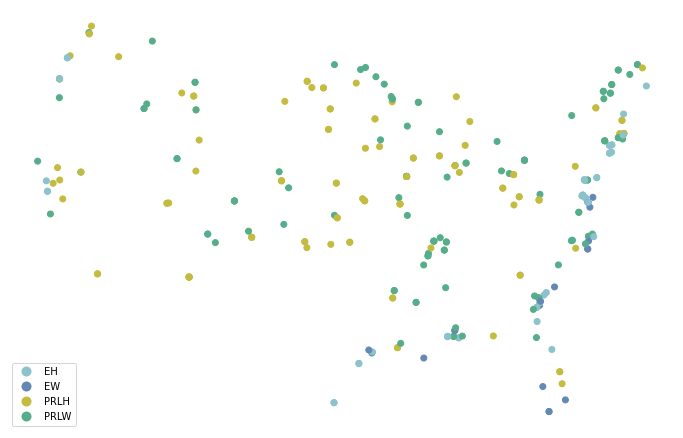

In [7]:
# make geodataframe
sites_gdf = gpd.GeoDataFrame(sites.copy(), geometry=gpd.points_from_xy(sites[("Longitude", "2016")], sites[("Latitude", "2016")]))
# set existing CRS
sites_gdf[("geometry", "")].set_crs("EPSG:4269", inplace=True)
#sites_gdf.set_geometry(("geometry", ""), inplace=True)
# reproject
sites_gdf[("geometry", "")] = sites_gdf[("geometry", "")].to_crs(global_crs)
# set new CRS
#sites_gdf[("geometry", "")].set_crs(global_crs, inplace=True)
sites_gdf.set_geometry(("geometry", ""), inplace=True)

# plot result
fig, ax = plt.subplots()
sites_gdf.plot(column=("WetlandCat","2016"), legend=True, cmap=gen_cmap(catcolors), ax=ax)
ax.axis("off")
fig.set_size_inches(12, 12)
plt.show()

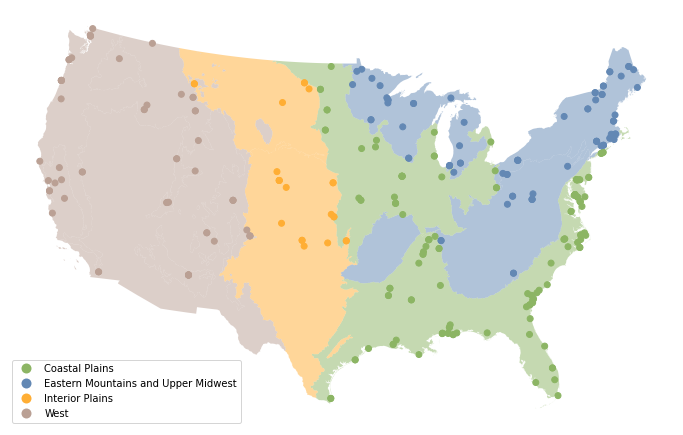

In [79]:
# get ecoregions, convert from 9-level to 4-level for NWCA
#ecoregions = gpd.read_file(os.path.join("data", "ecoregions", "Aggr_Ecoregions_2015.shp")).to_crs(global_crs)
ecoregions = unzip_shapefile("Aggr_Ecoregions_2015.zip").to_crs(global_crs)
region_names = ["CPL", "EMU", "IPL", "W"]
region_colors = ["#8CB564", "#6388B4", "#FFAE34", "#BAA094"]
ecoregions["WSA4"] = ["EMU" if x in ["NAP", "SAP", "UMW"]
                        else "IPL" if x in ["NPL", "SPL"]
                        else "W" if x in ["XER", "WMT"]
                        else "CPL" for x in ecoregions["WSA9"]]
ecoregions["WSA4"] = ecoregions["WSA4"].astype("category").cat.set_categories(region_names)

full_names = {
    "CPL": "Coastal Plains", 
    "EMU": "Eastern Mountains and Upper Midwest",
    "IPL": "Interior Plains",
    "W": "West",
}
ecoregions["WSA4_Name"] = [full_names[x] for x in ecoregions["WSA4"]]
ecoregions["WSA4_Name"] = ecoregions["WSA4_Name"].astype("category").cat.set_categories(full_names.values())

points = gpd.GeoDataFrame(flatten_columns(gpd.GeoDataFrame(sites_gdf.geometry.copy())), crs=sites_gdf.geometry.crs)
site_regions = gpd.sjoin(points, ecoregions, how="left", op="within")

# plot ecoregions by site
fig, ax = plt.subplots()
ecoregions.plot(column="WSA4_Name", ax=ax, alpha=0.5, cmap=gen_cmap(region_colors))
site_regions.plot(column="WSA4_Name", ax=ax, legend=True, cmap=gen_cmap(region_colors))
ax.axis("off")
fig.set_size_inches(12, 12)
plt.show()

# add to site table
sites["ecoregion"] = site_regions["WSA4"]

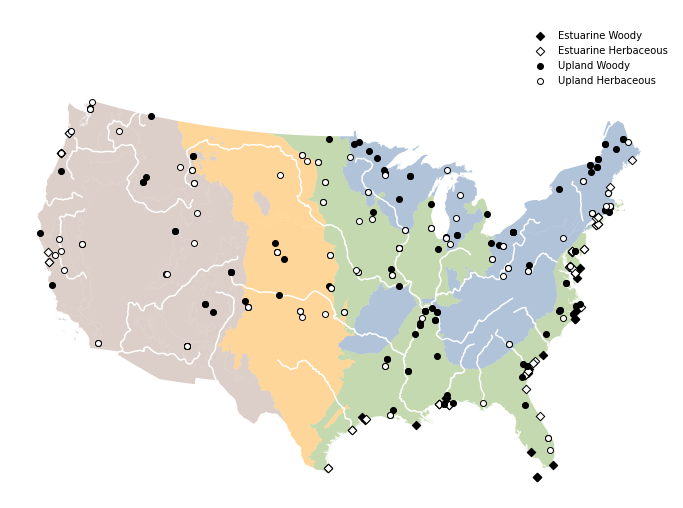

In [80]:
rivers = cartopy.io.shapereader.natural_earth(
        resolution="50m",
        category="physical",
        name="rivers_lake_centerlines")
rivers = gpd.read_file(rivers).to_crs(global_crs)
bbx = gpd.GeoSeries(shapely.geometry.box(-124.848974, 24.396308, -66.885444, 49.384358)).set_crs("EPSG:4326").to_crs(global_crs)
xmin, ymin, xmax, ymax = bbx.total_bounds
rivers = rivers["geometry"].explode().cx[xmin:xmax, ymin:ymax]

fig, ax = plt.subplots()
ecoregions.plot(column="WSA4_Name", ax=ax, alpha=0.5, cmap=gen_cmap(region_colors), legend=True, zorder=0)
rivers.plot(ax=ax, color="white", zorder=1)
leg = ax.get_legend()
flatten_columns(sites_gdf).query("d_estuarine_2011==1 & d_woody_2011==1")["geometry"].plot(ax=ax, edgecolor="black", facecolor="black", marker="D")
flatten_columns(sites_gdf).query("d_estuarine_2011==1 & d_woody_2011==0")["geometry"].plot(ax=ax, edgecolor="black", facecolor="white", marker="D")
flatten_columns(sites_gdf).query("d_estuarine_2011==0 & d_woody_2011==1")["geometry"].plot(ax=ax, edgecolor="black", facecolor="black", marker="o")
flatten_columns(sites_gdf).query("d_estuarine_2011==0 & d_woody_2011==0")["geometry"].plot(ax=ax, edgecolor="black", facecolor="white", marker="o")
ax.legend(["", "Estuarine Woody", "Estuarine Herbaceous", "Upland Woody", "Upland Herbaceous"], frameon=False)
#plt.gca().add_artist(leg)
ax.axis("off")
fig.set_size_inches(12, 12)
plt.show()

## TerraClimate
- download automatically via NetCDFsubset API
- catalog: http://thredds.northwestknowledge.net:8080/thredds/catalog/TERRACLIMATE_ALL/data/catalog.html 

In [10]:
# extracting values takes about 30 seconds for each var/year in addition to download time (~100 MB each)
def extract_values_to_points(ds: xr.Dataset, varname: str, pts: gpd.GeoSeries) -> pd.DataFrame:
    def timeseries_from_raster(pt: shapely.geometry.Point) -> pd.Series:
        return ds.sel(lon=pt.x, lat=pt.y, method="nearest").to_dataframe()[varname]
    return pts.apply(timeseries_from_raster).stack().rename(varname)

# define parameters of files to get
tc_vars = ["ppt", "pet", "aet", "def", "PDSI"] 
dirname = "tc"

# points at which to extract values
pts = gpd.GeoDataFrame(sites_gdf[("geometry", "")].to_crs("EPSG:4326"))["geometry"]

d = {}
if not os.path.exists(dirname):
    os.mkdir(dirname)
for v in tc_vars:
    # URL for TerraClimate data over contiguous USA for 2007-2016
    url = f"http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_terraclimate_{v}_1958_CurrentYear_GLOBE.nc?var={v}&north=51&west=-125&east=-67&south=24&disableProjSubset=on&horizStride=1&time_start=2007-01-01T00%3A00%3A00Z&time_end=2016-12-31T00%3A00%3A00Z&timeStride=1&accept=netcdf"
    destname = os.path.join(dirname, f"TerraClimate_{v}.nc")
    if not os.path.exists(destname):
        urllib.request.urlretrieve(url, destname)
    with xr.open_dataset(destname).rio.write_crs("EPSG:4326").rio.set_spatial_dims(x_dim="lon", y_dim="lat") as ds:
        d[v] = extract_values_to_points(ds=ds, varname=v, pts=pts)

extracted = (pd.concat(d, names=["varname"])
        .rename("value")
        .unstack("varname")
        .assign(aridity = lambda d: np.where(d["pet"] > 0, d["ppt"] / d["pet"], np.nan))
        .reset_index()
        .assign(year = lambda d: [x.year for x in d["time"]])
        .set_index(["UID11", "UID16", "year", "time"])
)

tc_years = (extracted
        .groupby(["UID11", "UID16", "year"])
        .agg(["min", "mean", "max", "std"])
        .pipe(flatten_columns)
        .rename_axis(["varname"], axis="columns")
)

tc_2007_16 = tc_years.groupby(["UID11", "UID16"]).mean()
tc_2011 = tc_years.loc[idx[:, :, 2011]]
tc_2016 = tc_years.loc[idx[:, :, 2016]]
tc_DIFF = tc_2016 - tc_2011

df_tc = (pd.concat([tc_2007_16.assign(year=""), 
           tc_2011.assign(year="2011"), 
           tc_2016.assign(year="2016"), 
           tc_DIFF.assign(year="DIFF")], axis="rows")
        .set_index("year", append=True)
        .unstack()
)

sites = sites.join(df_tc, how="left")

# LOG TRANSFORM OF RIGHT-TAILED VARIABLES

vars_to_log = ["def_mean", "def_max"]
for v in vars_to_log:
    for y in ["", "2011", "2016"]:
        sites[(f"log_{v}", y)] = np.where(sites[v, y]>0, np.log(sites[v, y]), np.nan)
    sites[(f"log_{v}", "DIFF")] = sites[(f"log_{v}", "2016")] - sites[(f"log_{v}", "2011")]

# PRINCIPAL COMPONENTS

X = flatten_columns(sites)[["ppt_mean", "def_mean", "aet_mean"]]
climate_mean_pc = PCA(n_components=2).fit_transform(X)
sites[("climate_mean_pc1", "")], sites[("climate_mean_pc2", "")] = zip(*climate_mean_pc)

X = flatten_columns(sites)[["ppt_std", "def_std", "aet_std"]]
climate_std_pc = PCA(n_components=2).fit_transform(X)
sites[("climate_std_pc1", "")], sites[("climate_std_pc2", "")] = zip(*climate_std_pc)

X = flatten_columns(sites)[["ppt_mean_DIFF", "def_mean_DIFF", "aet_mean_DIFF"]]
climate_diff_pc = PCA(n_components=2).fit_transform(X)
sites[("climate_diff_pc1", "")], sites[("climate_diff_pc2", "")] = zip(*climate_diff_pc)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Exploratory data visualization

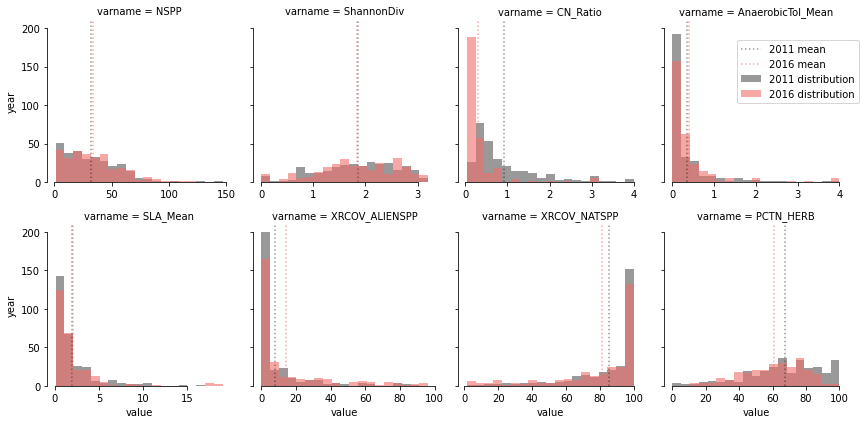

In [11]:
vars_to_plot = [
        "NSPP", "ShannonDiv", 
        "CN_Ratio", 
        "AnaerobicTol_Mean", 
        "SLA_Mean", 
        "XRCOV_ALIENSPP", 
        "XRCOV_NATSPP", 
        "PCTN_HERB", 
]

def plot_hist_grouped(x, hue, n_bins=10, color=None, palette=None, **kwargs):
    bins = np.linspace(x.min(), x.max(), n_bins)
    for i, (_, x_i) in enumerate(x.groupby(hue)):
        x_mean = x_i.mean()
        if palette:
            plt.hist(x_i, bins, color=palette[i], **kwargs)
            plt.axvline(x=x_mean, linestyle=":", color=palette[i])
        else:
            plt.hist(x_i, bins, **kwargs)
            plt.axvline(x=x_mean, linestyle=":")


d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        [vars_to_plot]
        .stack("varname")
        .rename("value")
        .reset_index(["varname", "year"])
        )
g = sns.FacetGrid(data=d, col="varname", col_wrap=4, sharex=False)
g.map(plot_hist_grouped, "value", "year", n_bins=20, palette=["#00000066", "#EF6F6A99"])
g.fig.legend(["2011 mean", "2016 mean", "2011 distribution", "2016 distribution"]).set_bbox_to_anchor((1, 0.9))
sns.despine(trim=True)
plt.show()

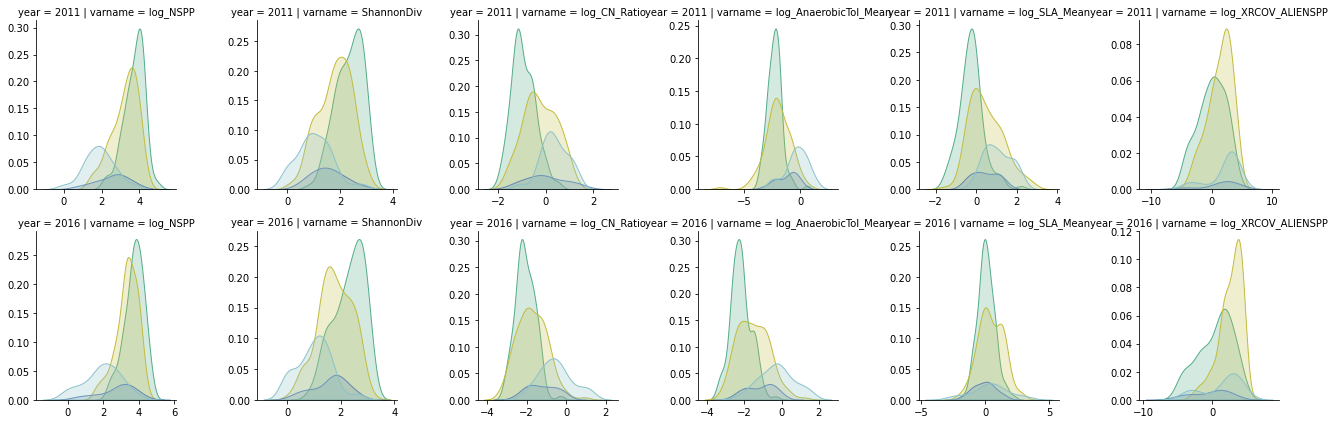

In [12]:
vars_to_plot2 = ["log_NSPP", "ShannonDiv", "log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean", "log_XRCOV_ALIENSPP"]
d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        .set_index(["WetlandCat"], append=True)
        [vars_to_plot2]
        .stack("varname")
        .rename("value")
        .reset_index(["varname", "year", "WetlandCat"])
        .dropna()
        )

d["varname"] = d["varname"].astype("category").cat.set_categories(vars_to_plot2)
d["WetlandCat"] = d["WetlandCat"].astype("category").cat.set_categories(wetlandcats)

g = sns.FacetGrid(data=d, col="varname", row="year", sharex=False, sharey=False)
g.map_dataframe(sns.kdeplot, x="value", hue="WetlandCat", palette=catcolors, shade=True)
g.add_legend()
sns.despine()
plt.show()

# horizontal = 2011, vertical = 2016 (above diagonal = increase, below diagonal = decrease )

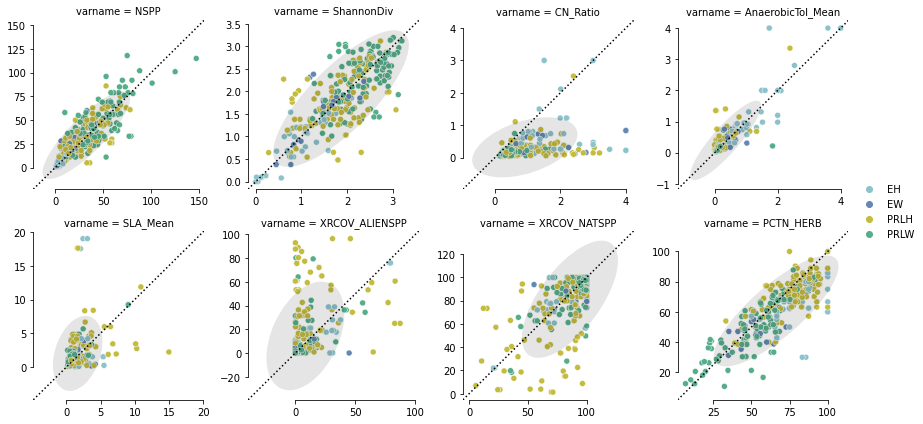

In [13]:
def plot_twoway_symmetrical(*args, **kwargs):
    sp = sns.scatterplot(*args, **kwargs)
    ax = sp.axes
    if "data" in kwargs:
        x = kwargs["data"][kwargs["x"]]
        y = kwargs["data"][kwargs["y"]]
    else:
        x = kwargs["x"]
        y = kwargs["y"]
    ax.add_patch(make_ellipse(x=x, y=y, 
        facecolor="black", alpha=0.1, type="error", n_std=2))
    std_min = min(ax.get_xlim() + ax.get_ylim())
    std_max = max(ax.get_xlim() + ax.get_ylim())
    std_lim = (std_min, std_max)
    ax.set_xlim(std_lim)
    ax.set_ylim(std_lim)
    sns.lineplot(ax=ax, color="black", linestyle=":", x=std_lim, y=std_lim)
    sns.despine(trim=True, ax=ax)
    return sp

d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        .set_index(["WetlandCat"], append=True)
        [vars_to_plot]
        .unstack("year")
        .stack("varname")
        .reset_index(["varname", "WetlandCat"])
        .dropna()
        )

d["varname"] = d["varname"].astype("category").cat.set_categories(vars_to_plot)
d["WetlandCat"] = d["WetlandCat"].astype("category").cat.set_categories(wetlandcats)

g = sns.FacetGrid(data=d, col="varname", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(plot_twoway_symmetrical, x="2011", y="2016", hue="WetlandCat", ci=False, palette=catcolors)
g.add_legend()
plt.show()

# horizontal = 2011, vertical = 2016 (above diagonal = increase, below diagonal = decrease )

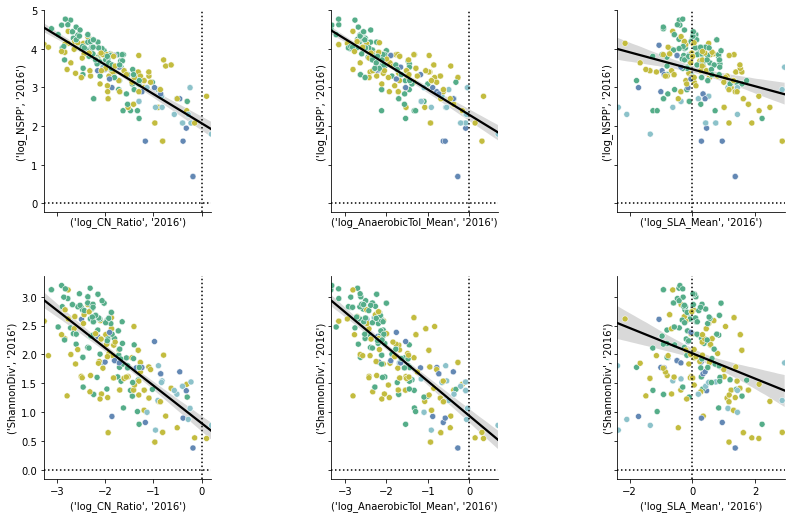

In [14]:
# C:N ratio, Anaerobic tolerance and SLA (specific leaf area)) correlate with changes in species richness or Shannon diversity

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars), len(x_vars), sharex="col", sharey="row")
for i, y in enumerate(y_vars):
    for j, x in enumerate(x_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "2016")], y=d[(y, "2016")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "2016")], y=d[(y, "2016")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
        axs[i, j].axvline(x=0, color="black", linestyle=":")
sns.despine()
plt.tight_layout()
fig.set_size_inches(12,8)
plt.show()

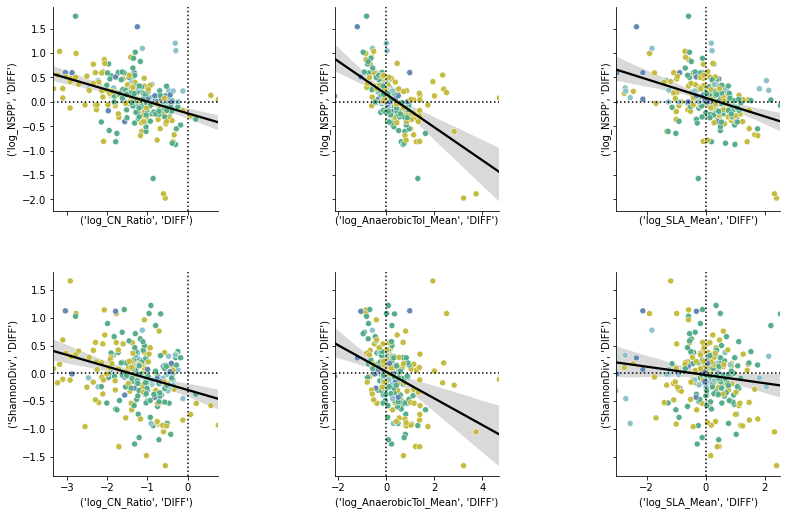

In [15]:
# C:N ratio, Anaerobic tolerance and SLA (specific leaf area)) correlate with changes in species richness or Shannon diversity

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars), len(x_vars), sharex="col", sharey="row")
for i, y in enumerate(y_vars):
    for j, x in enumerate(x_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "DIFF")], y=d[(y, "DIFF")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "DIFF")], y=d[(y, "DIFF")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
        axs[i, j].axvline(x=0, color="black", linestyle=":")
sns.despine()
plt.tight_layout()
fig.set_size_inches(12,8)
plt.show()

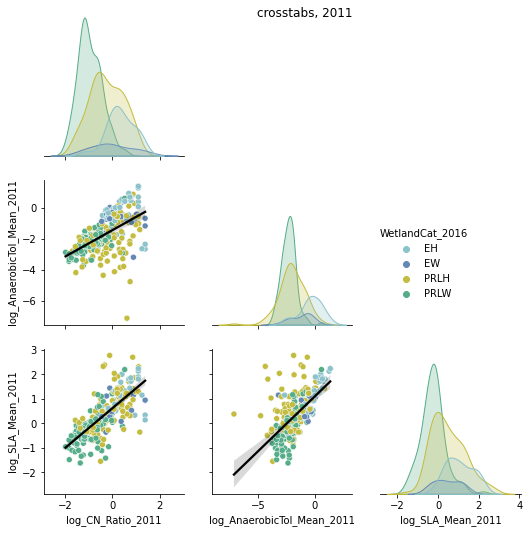

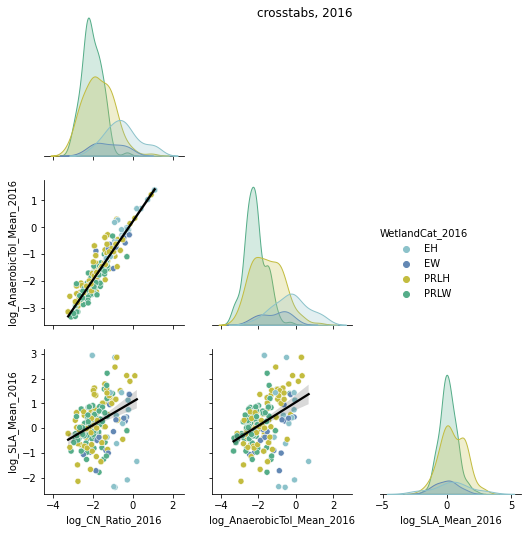

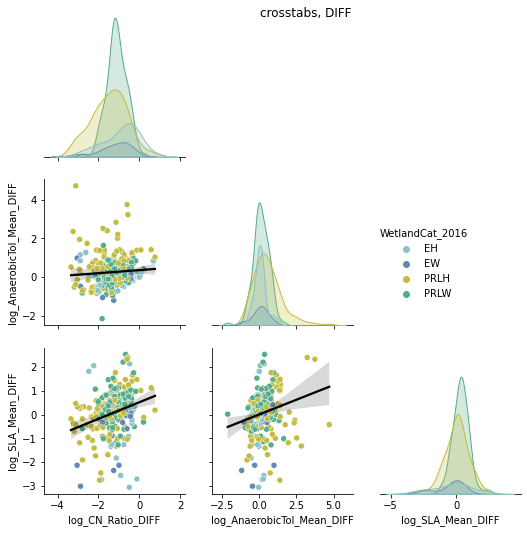

In [16]:
# crosstabs of traits

def plot_offdiag(hue, palette, *args, **kwargs):
    g = sns.scatterplot(x=kwargs["x"], y=kwargs["y"], hue=hue, palette=palette)
    h = sns.regplot(x=kwargs["x"], y=kwargs["y"], scatter=False, ax=g.axes, color="black")
    return g

for yr in ["2011", "2016", "DIFF"]:
    d = flatten_columns(sites)[["WetlandCat_2016", f"log_CN_Ratio_{yr}", f"log_AnaerobicTol_Mean_{yr}", f"log_SLA_Mean_{yr}"]] #, f"log_NSPP_{yr}", f"ShannonDiv_{yr}"]] #.dropna()
    g = sns.PairGrid(d, corner=True, hue="WetlandCat_2016")
    g.map_diag(sns.kdeplot, hue=d["WetlandCat_2016"], palette=catcolors, fill=True)
    g.map_offdiag(plot_offdiag, hue=d["WetlandCat_2016"], palette=catcolors)
    g.fig.suptitle(f"crosstabs, {yr}")
    g.add_legend()
    g._legend.set_bbox_to_anchor(((3/4), (1/2)))
    plt.show()

NSPP_DIFF
               count  mean   std    min   25%  50%   75%   max
REF_NWCA_2011                                                 
L              51.00  0.14 10.93 -29.00 -2.50 0.00  4.00 43.00
I             139.00  3.27 14.51 -46.00 -2.00 2.00 12.00 48.00
M              99.00  0.11 11.23 -33.00 -4.50 0.00  6.00 29.00
ShannonDiv_DIFF
               count  mean  std   min   25%   50%  75%  max
REF_NWCA_2011                                              
L              51.00 -0.04 0.40 -0.96 -0.28 -0.02 0.20 1.04
I             139.00 -0.01 0.48 -1.32 -0.25 -0.03 0.24 1.22
M              99.00 -0.05 0.56 -1.66 -0.39  0.04 0.21 1.66


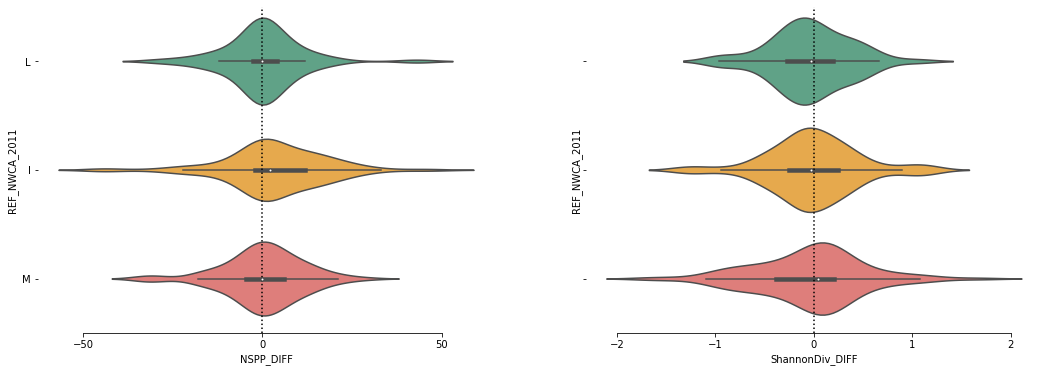

In [17]:
# disturbance level

fig, ax = plt.subplots(1, 2, sharey=True)
palette = ["#55AD89", "#FFAE34", "#EF6F6A"]
sns.violinplot(data=flatten_columns(sites), x="NSPP_DIFF", y="REF_NWCA_2011", palette=palette, ax=ax[0])
sns.violinplot(data=flatten_columns(sites), x="ShannonDiv_DIFF", y="REF_NWCA_2011", palette=palette, ax=ax[1])
ax[0].axvline(0, c="black", ls=":")
ax[1].axvline(0, c="black", ls=":")
sns.despine(trim=True, left=True)
fig.set_size_inches(18,6)

print("NSPP_DIFF")
print(flatten_columns(sites).groupby("REF_NWCA_2011")["NSPP_DIFF"].describe())
print("ShannonDiv_DIFF")
print(flatten_columns(sites).groupby("REF_NWCA_2011")["ShannonDiv_DIFF"].describe())

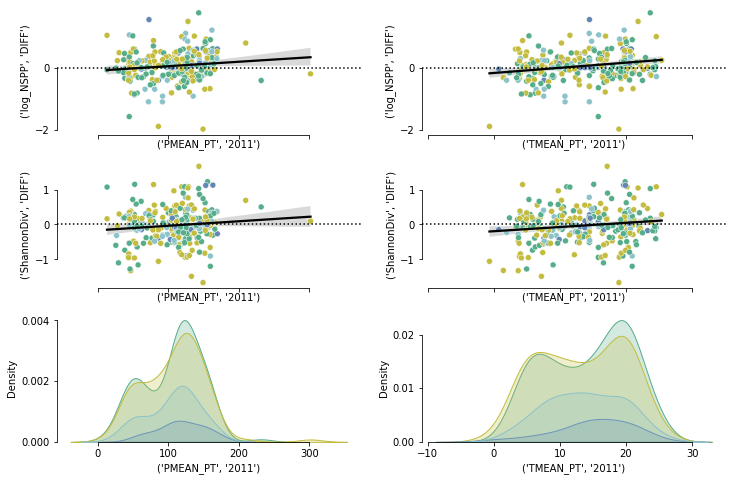

In [18]:
# temperature and precipitation

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["PMEAN_PT", "TMEAN_PT"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars) + 1, len(x_vars), sharex="col", sharey=False)
for j, x in enumerate(x_vars):
    for i, y in enumerate(y_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "2011")], y=d[(y, "DIFF")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "2011")], y=d[(y, "DIFF")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
    sns.kdeplot(ax=axs[-1, j], x=d[(x, "2011")], hue=d[("WetlandCat", "2016")], palette=catcolors, legend=False, shade=True)
sns.despine(trim=True)
#plt.tight_layout()
fig.set_size_inches(12,8)
plt.show()

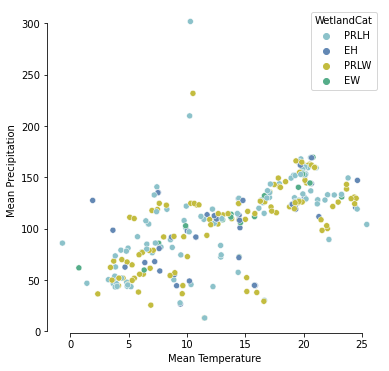

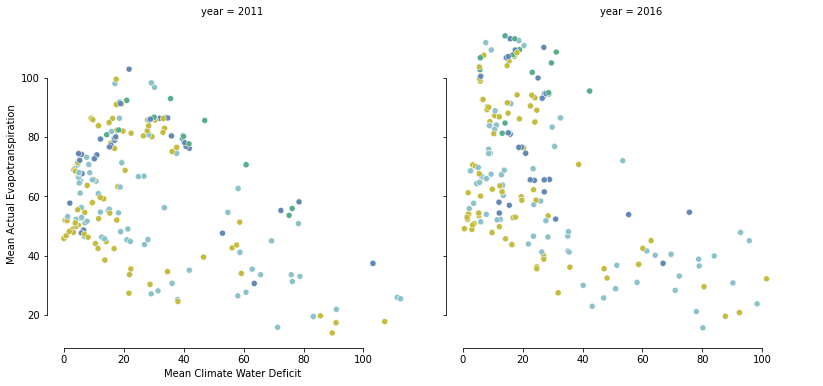

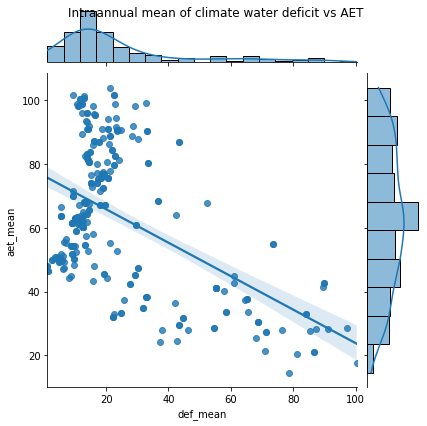

In [19]:
d = sites.stack("year").loc[idx[:, :, "2011"]]
fig, ax = plt.subplots()
sns.scatterplot(data=d, x="TMEAN_PT", y="PMEAN_PT", hue="WetlandCat", palette=catcolors, ax=ax)
ax.set(xlabel="Mean Temperature", ylabel="Mean Precipitation")
fig.set_size_inches(6,6)
sns.despine(trim=True)
plt.show()

d = sites.stack("year").query("year=='2011' | year=='2016'").reset_index("year")
g = sns.FacetGrid(data=d, col="year")
g.map_dataframe(sns.scatterplot, x="def_mean", y="aet_mean", hue="WetlandCat", palette=catcolors)
g.axes[0,0].set(xlabel="Mean Climate Water Deficit", ylabel="Mean Actual Evapotranspiration")
g.fig.set_size_inches(12,6)
sns.despine(trim=True)
plt.show()

g = sns.jointplot(data=flatten_columns(sites), x="def_mean", y="aet_mean", kind="reg")
g.fig.suptitle("Intraannual mean of climate water deficit vs AET")
plt.show()

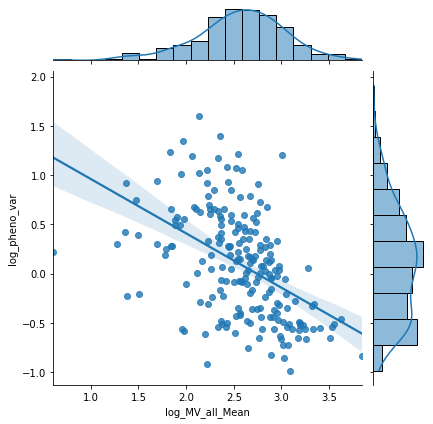

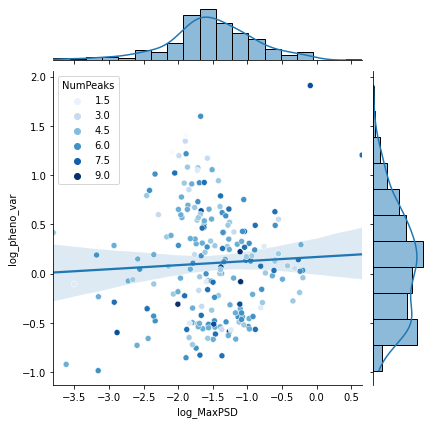

In [20]:
d = flatten_columns(sites)

sns.jointplot(data=d, x="log_MV_all_Mean", y="log_pheno_var", kind="reg")
plt.show()

g = sns.jointplot(data=d, y="log_pheno_var", x="log_MaxPSD", kind="reg", scatter=False)
sns.scatterplot(data=d, y="log_pheno_var", x="log_MaxPSD", hue="NumPeaks", ax=g.ax_joint, palette="Blues")
plt.show()

# Custom functions for modeling

Functions for executing regression and reporting results

In [21]:
def exec_ols(y: pd.Series, X: pd.DataFrame, standardize=True):
    dmat = pd.concat([y, X], axis="columns").dropna()
    if standardize:
        dmat[:] = scale(dmat[:]) # standardize the variables and don't fit intercept
        reg = sm.OLS(endog=dmat.iloc[:, 0], exog=dmat.iloc[:, 1:]).fit(covtype="HC0")
    else:
        reg = sm.OLS(endog=dmat.iloc[:, 0], exog=dmat.iloc[:, 1:].assign(intercept=1)).fit(covtype="HC0")
    return reg

def fit_models(df: pd.DataFrame, ys: list, Xs: dict) -> pd.DataFrame:
    regs = [[exec_ols(y = df[y], X = df[Xs[m]]) for m in Xs] for y in ys]
    regs = pd.DataFrame(regs, index=ys, columns=Xs).stack().rename("model")
    return regs

def output_results(regs: pd.Series) -> pd.DataFrame:

    out_rsq = regs.apply(lambda x: x.rsquared).rename_axis(["y", "model"]).rename("_outputs")
    out_aic = regs.apply(lambda x: x.aic).rename_axis(["y", "model"]).rename("_outputs")

    params = regs.apply(lambda x: x.params).rename_axis(["variable"], axis="columns").rename_axis(["y", "model"])
    pvalues = regs.apply(lambda x: x.pvalues).rename_axis(["variable"], axis="columns").rename_axis(["y", "model"])
    
    params = params.applymap(lambda x: f"+{abs(x):0.2f}" if x>0 else f"−{abs(x):0.2f}" if x<0 else "—" if x==0 else "").applymap(lambda x: "" if x=="nan" else x)
    pvalues = pvalues.applymap(lambda x: "***" if x<0.01 else "**" if x<0.05 else "*" if x<0.1 else "").applymap(lambda x: "" if x=="nan" else x)

    if "intercept" in params.columns:
        varnames = list(params.columns.drop("intercept")) + ["intercept"] + ["_outputs"]
    else:
        varnames = list(params.columns) + ["_outputs"]
    varnames_dtype = pd.CategoricalDtype(categories=reversed(varnames), ordered=True)
    params.columns = params.columns.astype(varnames_dtype)
    pvalues.columns = pvalues.columns.astype(varnames_dtype)

    return (pd.concat([params.T.assign(output="coeff"), 
                pvalues.T.assign(output="P"), 
                pd.DataFrame(out_rsq).T.assign(output="R2_adj"),
                pd.DataFrame(out_aic).T.assign(output="AIC"),
                ])
            .set_index(["output"], append=True)
            .sort_index(level=0, ascending=False)
            .fillna("")
            )

def test_vif(df: pd.DataFrame, Xs: list, sqrt: bool=True):
    def qvif(d):
        v = [variance_inflation_factor(d.values, i) for i in range(d.shape[1])]
        return pd.Series(v, index = d.columns)
    vif = pd.DataFrame({k: qvif(df[Xs[k]].dropna()) for k in Xs})
    vif = vif.reindex(vif.max(axis="columns").sort_values(ascending=False).index)
    if sqrt:
        return np.sqrt(vif)
    else:
        return vif

def test_sked(regs: list):
    s = regs.apply(lambda m: het_breuschpagan(m.resid, m.model.exog))
    hbp = pd.DataFrame.from_dict(dict(zip(s.index, s.values)))
    hbp.index = ["LMS", "P(LMS)", "F", "P(F)"]
    return hbp

Functions for executing lasso regression (L2 regularization)

In [22]:
def lasso_refit(df, y_var, X_vars, alpha=1.0, zero_tol=0.01):

    dmat = df[[y_var] + X_vars].copy().dropna()
    dmat[:] = scale(dmat[:])
    reg = sm.OLS(endog=dmat[y_var], exog=dmat[X_vars]).fit(covtype="HC0")
    reg_lasso = sm.OLS(endog=dmat[y_var], exog=dmat[X_vars]).fit_regularized(method="sqrt_lasso", alpha=alpha, zero_tol=zero_tol)
    reg_lasso_params = reg_lasso.params.loc[np.absolute(reg_lasso.params) > zero_tol]
    
    if len(reg_lasso_params) > 0:
        reg_refit = sm.OLS(endog=dmat[y_var], exog=dmat[reg_lasso_params.index]).fit(covtype="HC0")
    else:
        reg_refit = None
    
    return (reg, reg_lasso, reg_refit)

def exec_lasso(df, y_var, X_vars):

    regs = pd.Series({a: lasso_refit(df, y_var, X_vars, alpha=a) for a in np.arange(1,100)})

    def get_aic(reg):
        try: 
            aic = reg.aic
        except AttributeError:
            aic = np.nan
        return aic

    alpha_optimized = regs.apply(lambda x: get_aic(x[2])).idxmin()
    
    return regs.loc[alpha_optimized][2]

def fit_models_lasso(df: pd.DataFrame, ys: list, Xs: dict) -> pd.DataFrame:
    regs = [[exec_lasso(df, y, Xs[m]) for m in Xs] for y in ys]
    regs = pd.DataFrame(regs, index=ys, columns=Xs).stack().rename("model")
    return regs

Functions for plotting results

In [23]:
def plot_estimates(reg, alpha=0.05):
    d = pd.concat([reg.params, reg.HC0_se, reg.conf_int(alpha=alpha)], axis="columns").rename_axis("variable")
    d.columns = ["param", "se", "ci_min", "ci_max"]
    tcrit = scipy.stats.t.ppf(1 - alpha, reg.df_resid)
    d = (d
        .sort_values("param")
        .reset_index()
        .assign(ci = lambda d: tcrit * d["se"])
        .assign(significant = lambda d: np.sign(d["param"] + d["ci"]) == np.sign(d["param"] - d["ci"]))
        )
    fig, ax = plt.subplots()
    plt.errorbar(y=d["variable"], x=d["param"], xerr=d["ci"]*~d["significant"], ls="none", color="#AAAAAA")
    plt.errorbar(y=d["variable"], x=d["param"], xerr=d["ci"]*d["significant"], ls="none", color="#000000")
    sns.pointplot(ax=ax, y=d["variable"], x=d["param"], hue=d["significant"], join=False, palette=["#AAAAAA", "#000000"])
    plt.axvline(x=0, ls=":", color="black")
    plt.xlabel("standardized parameter estimate")
    plt.ylabel("")
    sns.despine(ax=ax, trim=True)
    fig.set_size_inches(8, 8)
    ax.legend(title=f"P<{alpha}")
    return ax

# Modeling

## setup

Define categories of variable lists to use, and combinations of these variables into models

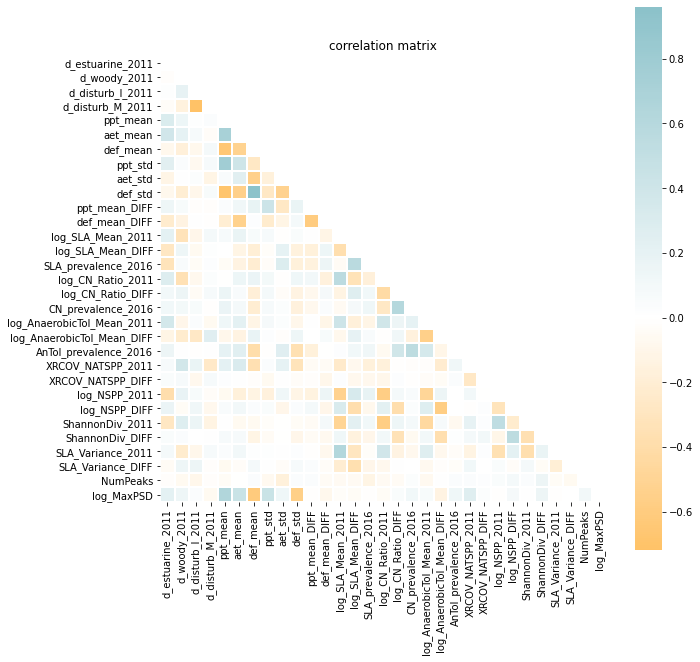

In [161]:
# GROUPS OF VARIABLES
vars_attributes = ["d_estuarine_2011", "d_woody_2011"]
vars_disturb = ["d_disturb_I_2011", "d_disturb_M_2011"]

vars_climate = ["ppt_mean", "aet_mean", "def_mean"]
vars_climate_variability = ["ppt_std", "aet_std", "def_std"]
vars_dif_climate = ["ppt_mean_DIFF", "def_mean_DIFF"]

vars_traits_SL = ["log_SLA_Mean_2011", "log_SLA_Mean_DIFF", "SLA_prevalence_2016"]
vars_traits_CN = ["log_CN_Ratio_2011", "log_CN_Ratio_DIFF", "CN_prevalence_2016"]
vars_traits_AT = ["log_AnaerobicTol_Mean_2011", "log_AnaerobicTol_Mean_DIFF", "AnTol_prevalence_2016"]
vars_traits_NS = ["XRCOV_NATSPP_2011", "XRCOV_NATSPP_DIFF"]
vars_traits = vars_traits_SL + vars_traits_CN + vars_traits_AT + vars_traits_NS

#vars_diversity = ["log_NSPP_DIFF", "ShannonDiv_DIFF", "SLA_Variance_DIFF"]
vars_diversity_SR = ["log_NSPP_2011", "log_NSPP_DIFF"]
vars_diversity_SH = ["ShannonDiv_2011", "ShannonDiv_DIFF"]
vars_diversity_VS = ["SLA_Variance_2011", "SLA_Variance_DIFF"]
vars_diversity = vars_diversity_SR + vars_diversity_SH + vars_diversity_VS

vars_stab_ts = ["NumPeaks", "log_MaxPSD"]
vars_stability = ["MV_all_Mean", "MV_all_Max", "log_pheno_var"]

# X VARIABLES FOR DIVERSITY MODELS
dmodels2 = {
    "none": vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate, 
    "SL":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_SL,
    "CN":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_CN,
    "AT":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_AT, 
    "NS":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_NS, 
    "full": vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits, 
}

# X VARIABLES FOR STABILITY MODELS
smodels2 = {
    "none": vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate, 
    "SL":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_SL,
    "CN":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_CN,
    "AT":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_AT, 
    "NS":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_NS, 
    
    "SR":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_diversity_SR,
    "SH":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_diversity_SH,
    "VS":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_diversity_VS,
    #"div":  vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_diversity,
    
    "TS":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_stab_ts,
    "full": vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits + vars_diversity + vars_stab_ts,
}

# DEFINE FLATTENED DATAFRAME
df = flatten_columns(sites)

# PLOT CORRELATION MATRIX
yv = ["log_NSPP_DIFF", "ShannonDiv_DIFF", "MV_all_Mean", "MV_all_Max", "log_pheno_var"]
xv = dmodels2["full"] + [x for x in smodels2["full"] if x not in dmodels2["full"]]
df_scaled = df.copy().select_dtypes(include=np.number)
df_scaled[:] = scale(df_scaled[:])
x_corr = pd.DataFrame(np.cov(df_scaled[xv].dropna().T), index=xv, columns=xv)
fig, ax = plt.subplots()
sns.heatmap(x_corr, mask=np.triu(np.ones_like(x_corr, dtype=bool)), 
            ax=ax, xticklabels=True, yticklabels=True, 
            cmap=diverging_cmap, center=0, cbar=True, linewidths=1, linecolor="white")
fig.set_size_inches(10,10)
ax.set_aspect('equal')
ax.set_title("correlation matrix")
plt.show()

## run and output each model

y                                 log_NSPP_DIFF         ... ShannonDiv_DIFF       
model                                      none     SL  ...              NS   full
                           output                       ...                       
d_estuarine_2011           coeff          +0.01  +0.06  ...           +0.03  +0.04
                           P                            ...                       
d_woody_2011               coeff          −0.03  +0.05  ...           −0.04  +0.06
                           P                            ...                       
d_disturb_I_2011           coeff          +0.12  +0.13  ...           +0.01  +0.02
                           P                            ...                       
d_disturb_M_2011           coeff          +0.00  +0.03  ...           +0.00  +0.09
                           P                            ...                       
ppt_mean                   coeff          +0.17  +0.26  ...           +0.21  −0.00
                           P                            ...                       
aet_mean                   coeff          +0.02  −0.05  ...           −0.20  −0.17
                           P                            ...                       
def_mean                   coeff          +0.03  −0.23  ...           −0.43  −0.55
                           P                            ...              **    ***
ppt_std                    coeff          −0.12  −0.23  ...           −0.18  +0.03
                           P                            ...                       
aet_std                    coeff          −0.07  −0.09  ...           −0.14  −0.12
                           P                            ...                       
def_std                    coeff          +0.14  +0.33  ...           +0.40  +0.41
                           P                         *  ...               *     **
ppt_mean_DIFF              coeff          +0.06  +0.10  ...           −0.20  −0.21
                           P                            ...                       
def_mean_DIFF              coeff          −0.05  +0.04  ...           −0.31  −0.20
                           P                            ...              **       
log_SLA_Mean_2011          coeff                 +0.25  ...                  +0.20
                           P                       ***  ...                      *
log_SLA_Mean_DIFF          coeff                 −0.36  ...                  +0.13
                           P                       ***  ...                       
SLA_prevalence_2016        coeff                 +0.15  ...                  −0.19
                           P                         *  ...                     **
log_CN_Ratio_2011          coeff                        ...                  −0.36
                           P                            ...                       
log_CN_Ratio_DIFF          coeff                        ...                  −0.76
                           P                            ...                    ***
CN_prevalence_2016         coeff                        ...                  +0.26
                           P                            ...                       
log_AnaerobicTol_Mean_2011 coeff                        ...                  +0.23
                           P                            ...                       
log_AnaerobicTol_Mean_DIFF coeff                        ...                  −0.02
                           P                            ...                       
AnTol_prevalence_2016      coeff                        ...                  +0.02
                           P                            ...                       
XRCOV_NATSPP_2011          coeff                        ...           +0.11  +0.05
                           P                            ...               *       
XRCOV_NATSPP_DIFF          coeff                        ...           +0.04  +0.07
                

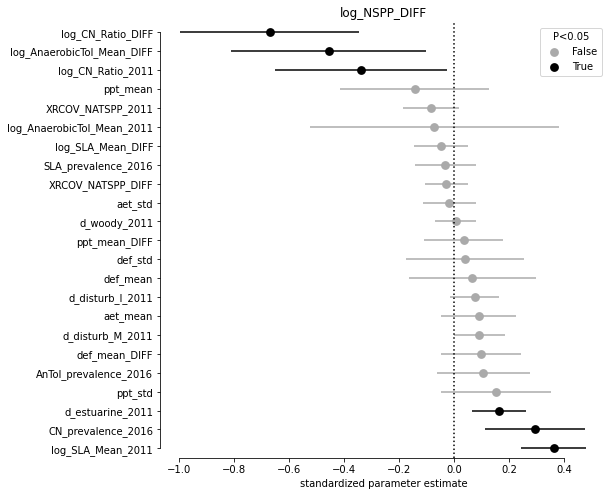

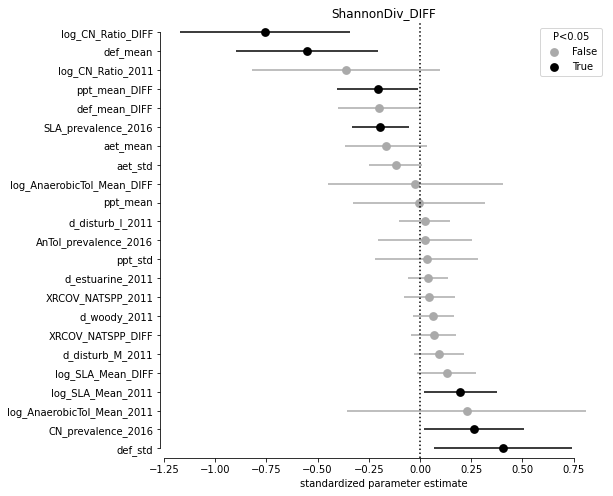

In [25]:
# DIVERSITY MODEL
ys = ["log_NSPP_DIFF", "ShannonDiv_DIFF"]
regs2_diversity = fit_models(df=df, ys=ys, Xs=dmodels2)
for y in ys:
    plot_estimates(regs2_diversity.loc[y].loc["full"]).set_title(y)
regs2_diversity_results = output_results(regs2_diversity)
regs2_diversity_results.to_csv("regs2_diversity.csv")
regs2_diversity_results

y                                 log_NSPP_DIFF         ... ShannonDiv_DIFF       
model                                      none     SL  ...              NS   full
                           output                       ...                       
d_estuarine_2011           coeff                        ...                       
                           P                            ...                       
d_woody_2011               coeff                        ...                       
                           P                            ...                       
d_disturb_I_2011           coeff          +0.11  +0.13  ...                       
                           P                  *     **  ...                       
d_disturb_M_2011           coeff                        ...                  +0.07
                           P                            ...                       
ppt_mean                   coeff                        ...                       
                           P                            ...                       
aet_mean                   coeff                        ...                       
                           P                            ...                       
def_mean                   coeff                        ...                  −0.41
                           P                            ...                     **
ppt_std                    coeff                        ...                       
                           P                            ...                       
aet_std                    coeff          −0.12  −0.14  ...                  −0.06
                           P                  *     **  ...                       
def_std                    coeff          +0.08         ...                  +0.33
                           P                            ...                      *
ppt_mean_DIFF              coeff                        ...                  −0.07
                           P                            ...                       
def_mean_DIFF              coeff          −0.10         ...                       
                           P                  *         ...                       
log_SLA_Mean_2011          coeff                 +0.23  ...                  +0.19
                           P                       ***  ...                     **
log_SLA_Mean_DIFF          coeff                 −0.35  ...                  +0.15
                           P                       ***  ...                      *
SLA_prevalence_2016        coeff                 +0.13  ...                  −0.22
                           P                         *  ...                    ***
log_CN_Ratio_2011          coeff                        ...                  −0.21
                           P                            ...                     **
log_CN_Ratio_DIFF          coeff                        ...                  −0.57
                           P                            ...                    ***
CN_prevalence_2016         coeff                        ...                  +0.19
                           P                            ...                      *
log_AnaerobicTol_Mean_2011 coeff                        ...                       
                           P                            ...                       
log_AnaerobicTol_Mean_DIFF coeff                        ...                  −0.22
                           P                            ...                    ***
AnTol_prevalence_2016      coeff                        ...                  +0.08
                           P                            ...                       
XRCOV_NATSPP_2011          coeff                        ...           +0.10       
                           P                            ...               *       
XRCOV_NATSPP_DIFF          coeff                        ...                  +0.08
                

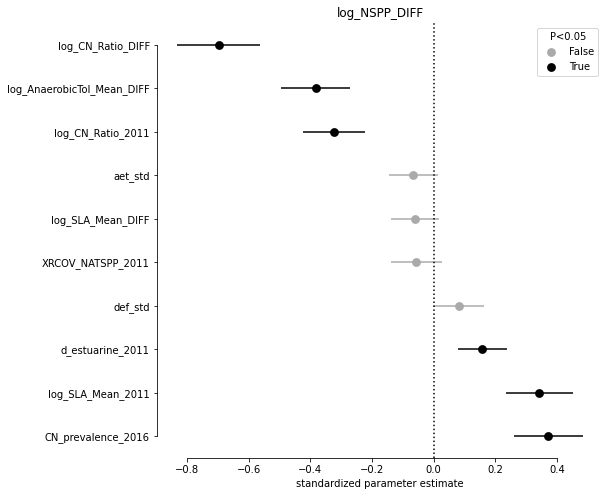

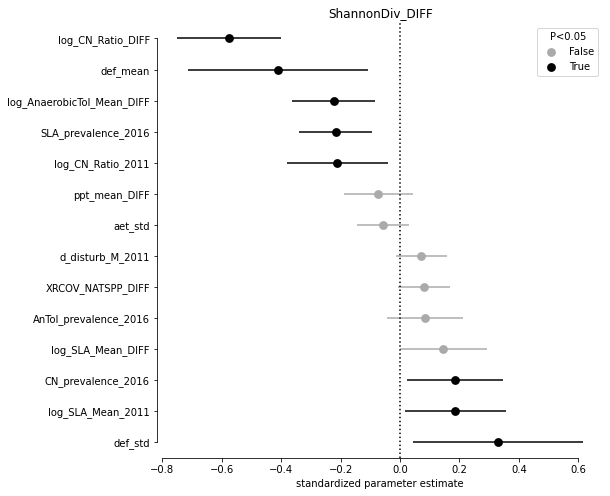

In [26]:
# DIVERSITY MODEL with lasso regularization for feature selection
ys = ["log_NSPP_DIFF", "ShannonDiv_DIFF"]
regs2_diversity_lasso = fit_models_lasso(df=df, ys=ys, Xs=dmodels2)
for y in ys:
    plot_estimates(regs2_diversity_lasso.loc[y].loc["full"]).set_title(y)
regs2_diversity_lasso_results = output_results(regs2_diversity_lasso).reindex(regs2_diversity_results.index, fill_value="")
regs2_diversity_lasso_results.to_csv("regs2_diversity_lasso.csv")
regs2_diversity_lasso_results

y                       MV_all_Mean                ... log_pheno_var              
model                          none     SL     CN  ...            VS     TS   full
                 output                            ...                            
d_estuarine_2011 coeff        −0.09  +0.02  −0.06  ...         +0.11  +0.08  +0.04
                 P                                 ...             *              
d_woody_2011     coeff        +0.23  +0.09  +0.14  ...         −0.05  −0.09  +0.05
                 P              ***            **  ...                    *       
d_disturb_I_2011 coeff        +0.00  −0.10  −0.04  ...         +0.06  +0.01  +0.08
...                             ...    ...    ...  ...           ...    ...    ...
NumPeaks         P                                 ...                   **       
log_MaxPSD       coeff                             ...                +0.35  +0.34
                 P                                 ...                  ***    ***
_outputs         R2_adj        0.34   0.40   0.39  ...          0.53   0.59   0.69
                 AIC         524.96 466.67 504.68  ...        457.96 430.98 373.31

[64 rows x 30 columns]

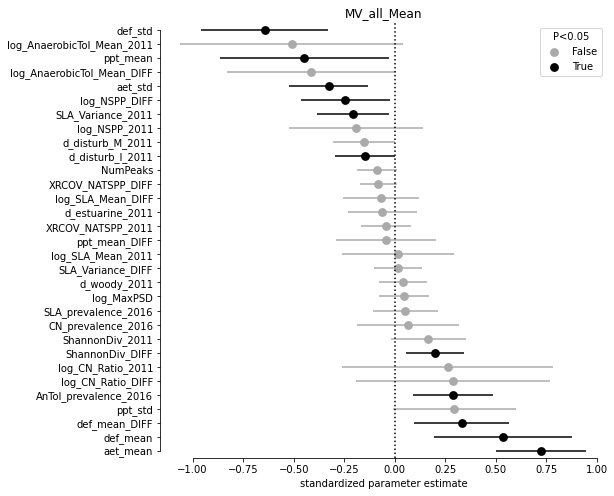

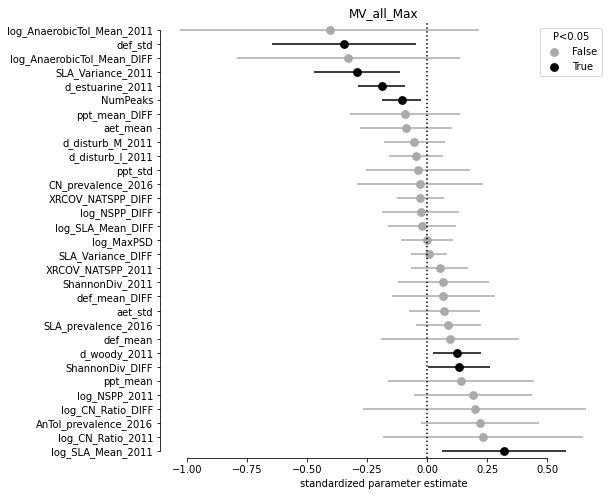

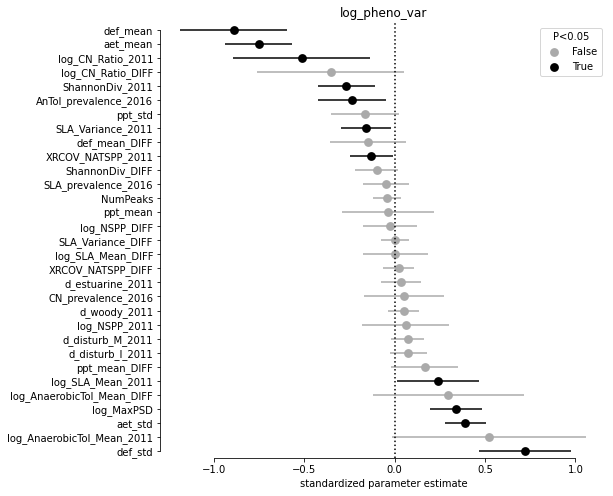

In [27]:
# STABILITY MODEL
ys = ["MV_all_Mean", "MV_all_Max", "log_pheno_var"]
regs2_stability = fit_models(df=df, ys=ys, Xs=smodels2)
for y in ys:
    plot_estimates(regs2_stability.loc[y].loc["full"]).set_title(y)
regs2_stability_results = output_results(regs2_stability)
regs2_stability_results.to_csv("regs2_stability.csv")
regs2_stability_results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

y                       MV_all_Mean                ... log_pheno_var              
model                          none     SL     CN  ...            VS     TS   full
                 output                            ...                            
d_estuarine_2011 coeff                      −0.07  ...         +0.10  +0.07       
                 P                                 ...             *              
d_woody_2011     coeff        +0.25  +0.11  +0.15  ...         −0.05  −0.10       
                 P              ***            **  ...                    *       
d_disturb_I_2011 coeff                             ...                            
...                             ...    ...    ...  ...           ...    ...    ...
NumPeaks         P                                 ...                   **       
log_MaxPSD       coeff                             ...                +0.35  +0.35
                 P                                 ...                  ***    ***
_outputs         R2_adj        0.33   0.38   0.39  ...          0.53   0.59   0.66
                 AIC         518.18 460.18 498.17  ...        451.11 427.34 356.56

[64 rows x 30 columns]

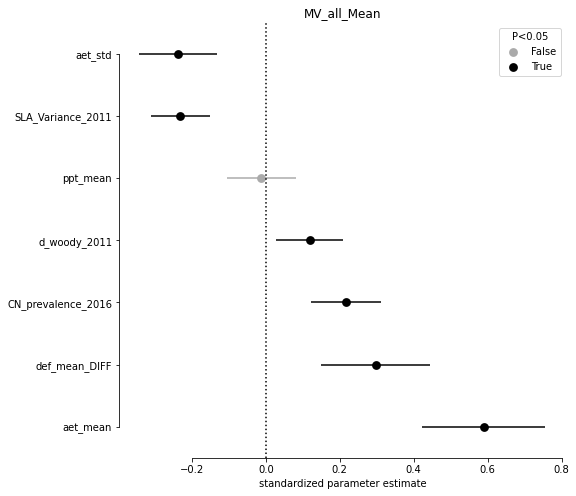

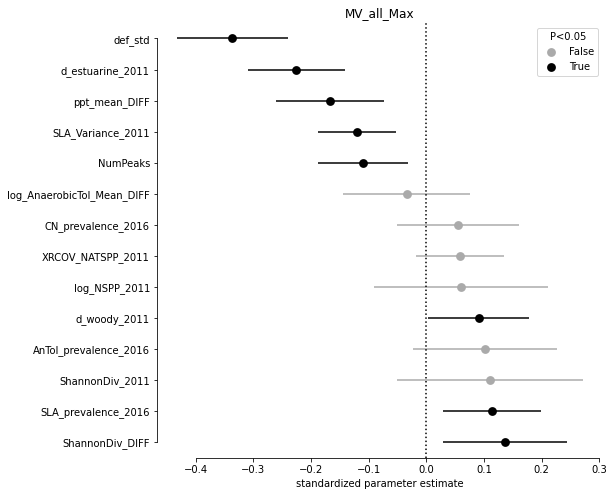

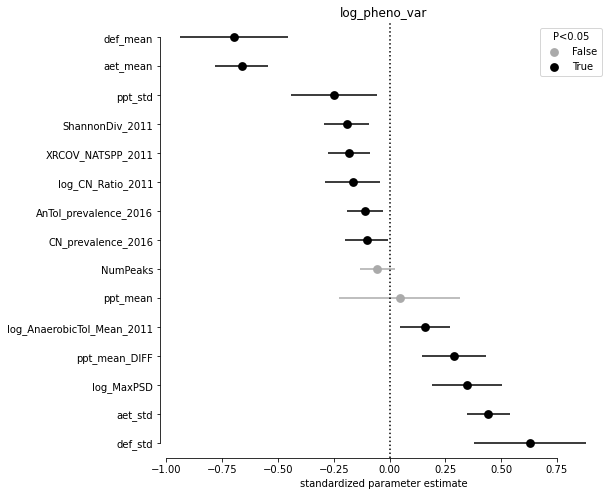

In [28]:
# STABILITY MODEL with lasso regularization for feature selection
ys = ["MV_all_Mean", "MV_all_Max", "log_pheno_var"]
regs2_stability_lasso = fit_models_lasso(df=df, ys=ys, Xs=smodels2)
for y in ys:
    plot_estimates(regs2_stability_lasso.loc[y].loc["full"]).set_title(y)
regs2_stability_lasso_results = output_results(regs2_stability_lasso).reindex(regs2_stability_results.index, fill_value="")
regs2_stability_lasso_results.to_csv("regs2_stability_lasso.csv")
regs2_stability_lasso_results

## summary output

summary view for full models (same results as above, displayed differently)

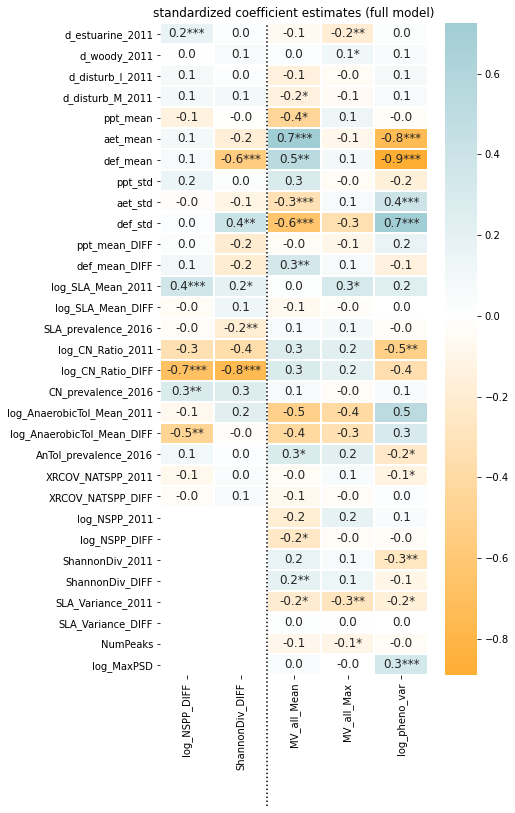

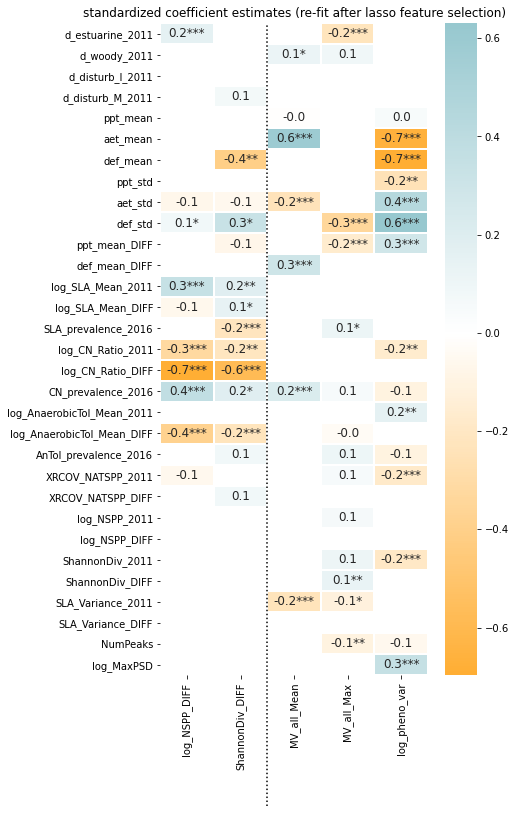

In [203]:
# collect the lists of full variables used for each model
full_model_vars ={
    "log_NSPP_DIFF": dmodels2["full"],
    "ShannonDiv_DIFF": dmodels2["full"],
    "MV_all_Mean": smodels2["full"],
    "MV_all_Max": smodels2["full"],
    "log_pheno_var": smodels2["full"],
}

# OLS COEFFICIENTS
full_models = {y: exec_ols(y=df[y], X=df[full_model_vars[y]]) for y in full_model_vars} 
full_model_params = {y: full_models[y].params for y in full_model_vars}
full_model_tvalues = {y: full_models[y].tvalues for y in full_model_vars}
full_model_pvalues = {y: full_models[y].pvalues for y in full_model_vars}

xs = dmodels2["full"] + [x for x in smodels2["full"] if x not in dmodels2["full"]]
full_model_params = pd.concat(full_model_params).unstack().T.reindex(pd.Index(xs))
full_model_tvalues = pd.concat(full_model_tvalues).unstack().T.reindex(pd.Index(xs))
full_model_pvalues = pd.concat(full_model_pvalues).unstack().T.reindex(pd.Index(xs))

significance_indicator = full_model_pvalues.applymap(lambda x: "***" if x<0.01 else "**" if x<0.05 else "*" if x<0.1 else "")
param_labels = full_model_params.applymap(lambda x: f"{x:0.1f}") + significance_indicator
#param_labels = full_model_params.applymap(lambda x: f"{x:{'+' if x>0 else '-'}0.1f}") + significance_indicator

fig, ax = plt.subplots()
sns.heatmap(
            full_model_params, cmap=diverging_cmap, center=0,
            ax=ax, xticklabels=True, yticklabels=True, 
            cbar=True, linewidths=1, linecolor="white",
            annot=param_labels, annot_kws={"size": 12}, fmt="")
ax.axvline(x=2, color="black", ls=":", clip_on=False, ymin=-0.2)
ax.set_title("standardized coefficient estimates (full model)")
fig.set_size_inches(6, 12)
plt.show()

# LASSO COEFFICIENTS
full_models = {y: exec_lasso(df=df, y_var=y, X_vars=full_model_vars[y]) for y in full_model_vars} 
full_model_params = {y: full_models[y].params for y in full_model_vars}
full_model_tvalues = {y: full_models[y].tvalues for y in full_model_vars}
full_model_pvalues = {y: full_models[y].pvalues for y in full_model_vars}

xs = dmodels2["full"] + [x for x in smodels2["full"] if x not in dmodels2["full"]]
full_model_params = pd.concat(full_model_params).unstack().T.reindex(pd.Index(xs))
full_model_tvalues = pd.concat(full_model_tvalues).unstack().T.reindex(pd.Index(xs))
full_model_pvalues = pd.concat(full_model_pvalues).unstack().T.reindex(pd.Index(xs))

significance_indicator = full_model_pvalues.applymap(lambda x: "***" if x<0.01 else "**" if x<0.05 else "*" if x<0.1 else "")
param_labels = full_model_params.applymap(lambda x: f"{x:0.1f}") + significance_indicator
#param_labels = full_model_params.applymap(lambda x: f"{x:{'+' if x>0 else '-'}0.1f}") + significance_indicator

fig, ax = plt.subplots()
sns.heatmap(
            full_model_params, cmap=diverging_cmap, center=0,
            ax=ax, xticklabels=True, yticklabels=True, 
            cbar=True, linewidths=1, linecolor="white",
            annot=param_labels, annot_kws={"size": 12}, fmt="")
ax.axvline(x=2, color="black", ls=":", clip_on=False, ymin=-0.2)
ax.set_title("standardized coefficient estimates (re-fit after lasso feature selection)")
fig.set_size_inches(6, 12)
plt.show()

In [157]:
result_outputs = pd.concat([pd.concat({"full": regs2_diversity_results.loc["_outputs"], "lasso": regs2_diversity_lasso_results.loc["_outputs"]}, axis="rows", names=["type", "output"]),
                            pd.concat({"full": regs2_stability_results.loc["_outputs"], "lasso": regs2_stability_lasso_results.loc["_outputs"]}, axis="rows", names=["type", "output"]),], axis="columns")

#print(result_outputs.loc["lasso"].loc["R2_adj"])

s = result_outputs.loc["lasso"].loc["R2_adj"].reset_index()
s["y"] = s["y"].astype("category").cat.set_categories(result_outputs.columns.get_level_values("y").unique())
s["model"] = s["model"].astype("category").cat.set_categories(smodels2.keys())
s = s.set_index(["y", "model"])
print(s.unstack())
s.unstack().T.to_csv("rsquared.csv")

                R2_adj                                             
model             none   SL   CN   AT   NS   SR   SH   VS   TS full
y                                                                  
log_NSPP_DIFF     0.04 0.25 0.42 0.45 0.04  NaN  NaN  NaN  NaN 0.63
ShannonDiv_DIFF   0.00 0.10 0.20 0.16 0.01  NaN  NaN  NaN  NaN 0.29
MV_all_Mean       0.33 0.38 0.39 0.37 0.33 0.38 0.36 0.38 0.33 0.41
MV_all_Max        0.46 0.47 0.50 0.50 0.46 0.48 0.49 0.48 0.46 0.52
log_pheno_var     0.52 0.55 0.54 0.55 0.53 0.54 0.54 0.53 0.59 0.66
